Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-03-15 по 2022-03-21 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import scipy.stats as stats
from read_db.CH import Getch

Я решила сравнить результаты двух методов: теста Манна-Уитни и теста Манна-Уитни поверх бакетного преобразования

Тест Манна-Уитни без дополнительных преобразований:

In [3]:
data = Getch('''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions
WHERE toDate(time) between '2022-03-15' and '2022-03-21'
    and exp_group in (1,2)
GROUP BY exp_group, user_id''').df

In [4]:
stats.mannwhitneyu(data[data.exp_group == 1].ctr,
                   data[data.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

То же, но в Clickhouse:

In [5]:
mw1 = Getch('''
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM (SELECT exp_group,
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220320.feed_actions
    WHERE toDate(time) between '2022-03-15' and '2022-03-21'
        and exp_group in (1,2)
    GROUP BY exp_group, user_id)
    ''').df
mw1

,statistic,p_value
0,56601260.5,1.655343e-13


Тест Манна-Уитни поверх бакетного преобразования:

In [6]:
mw2 = Getch('''
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220320.feed_actions
    WHERE toDate(time) between '2022-03-15' and '2022-03-21'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
''').df

In [13]:
stats.mannwhitneyu(mw2[mw2.exp_group == 1].bucket_ctr,
                   mw2[mw2.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Оба теста обнаруживают значимое различие между двумя группами. Посмотрим на граспределения:

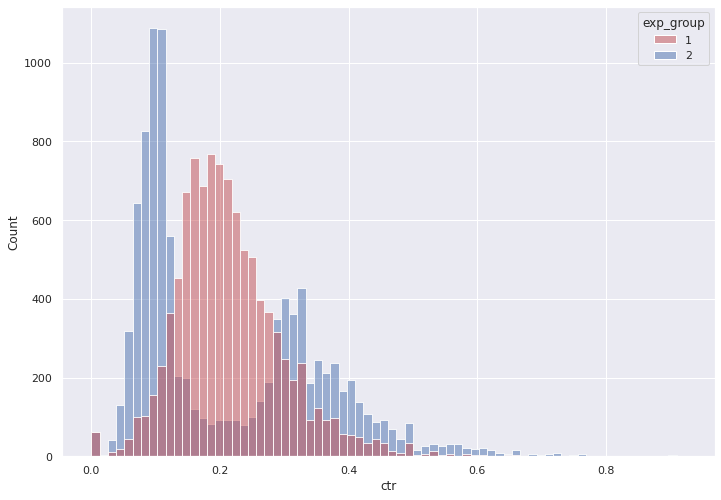

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = data,
                     x = 'ctr',
                     hue = 'exp_group',
                     palette = ['r', 'b'],
                     alpha = 0.5,
                     kde = False)


К сожалению, значимость тестов не означает, что новый алогритм улучшил показатели.

Распределение внутри группы 2 бимодально, пики лежат по разные стороны от пика контрольной группы, причем больший пик находится в стороне уменьшения CTR. Наши тесты уловили значимое отличие - но оно совсем не такое, какое мы хотели бы увидеть (сдвиг распределения CTR группы 2 вправо - в сторону увеличения показателя).

Возможно, половине пользователей новый алгоритм "понравился", и они стали больше лайкать, половине - наоборот. Если это был алогритм рекомендации похожих на лайкнутые постов, возможно, у наших пользователей разные стратегии лайкания: одни действительно лайкают то, что им нравится (и на них алгоритм мог "сработать"), а другие ставят вынужденные лайки фотографиям детей знакомых или вообще участвовали в каком-то конкрусе и лайкали то, что им по жизни особенно-то и не нравится.

Раскатывать алгоритм на всех новых пользователей точно не стоит.

На всякий случай посмотрим, какой резальтат дадут другие тесты:

t-тест:

In [8]:
stats.ttest_ind(data[data.exp_group == 1].ctr,
                   data[data.exp_group == 2].ctr,
                   equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

t-тест на сглаженном CTR:

In [9]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    smoothed_ctr = (user_likes + alpha * global_ctr)/(user_views + alpha)
    return smoothed_ctr

global_ctr_1 = data[data.exp_group == 1].likes.sum()/data[data.exp_group == 1].views.sum()
global_ctr_2 = data[data.exp_group == 2].likes.sum()/data[data.exp_group == 2].views.sum()

group1 = data[data.exp_group == 1].copy()
group1['smoothed_ctr'] = data.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2 = data[data.exp_group == 2].copy()
group2['smoothed_ctr'] = data.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

stats.ttest_ind(group1.smoothed_ctr,
                group2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [ ]:
t-тест поверх бакетного преобразования:

In [16]:
stats.ttest_ind(mw2[mw2.exp_group == 1].bucket_ctr,
                   mw2[mw2.exp_group == 2].bucket_ctr,
                   equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Обычный t-тест показал, что значимых различий между группами нет. Вероятно, потому, что пики CTR второй группы лежат примерно так, что средний CTR не сильно отличается от среднего CTR первой группы. t-тест на сглаженном CTR и t-тест поверх бакетного преобразования различие уже выявили, причем последний оказался чувствительнее и нашел более значимое различие.

t-тест поверх Пуассоновского бустрепа:

In [20]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
       (2000, len(likes1))).astype(np.int64)
    
    poisson_bootstraps2 = stats.poisson(1).rvs(
           (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

likes1 = data[data.exp_group == 1].likes.to_numpy()
views1 = data[data.exp_group == 1].views.to_numpy()
likes2 = data[data.exp_group == 2].likes.to_numpy()
views2 = data[data.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)

Ttest_indResult(statistic=268.2222596719344, pvalue=0.0)

<AxesSubplot:ylabel='Count'>

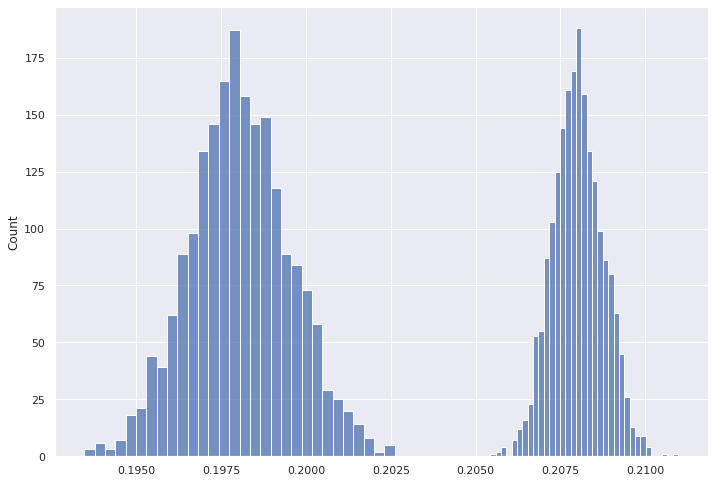

In [21]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Пуассановский бутстреп выявил значимое различие, причем распределения CTR 'разъехались' настолько, что p-value стал равен 0.